# GO/STOP! object detection 시스템 만들기
## 자율주행 보조장치 (1) KITTI Dataset
* 1) 사람이 카메라에 감지되면 정지
* 2) 차량이 일정 크기 이상으로 감지되면 정지

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), 'aiffel/object_detection/data')

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

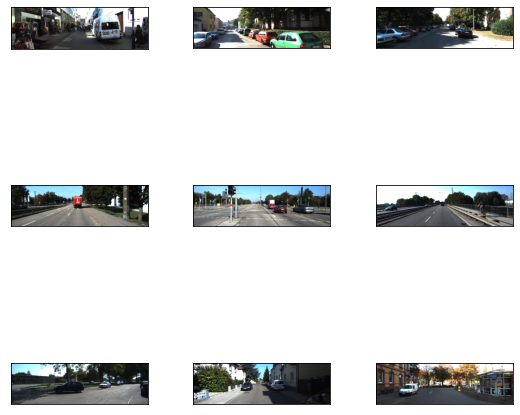

In [3]:
_ = tfds.show_examples(ds_train, ds_info)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

## (2) 데이터 직접 확인하기

----Example----
['image', 'image/file_name', 'objects']
-------objects------
{'alpha': <tf.Tensor: shape=(5,), dtype=float32, numpy=array([-1.85, -1.95, -2.  , -1.93, -1.68], dtype=float32)>, 'bbox': <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0.34330666, 0.6919565 , 0.582     , 0.73347825],
       [0.38808   , 0.7224477 , 0.5670133 , 0.7462238 ],
       [0.38874668, 0.74857485, 0.56976   , 0.76891303],
       [0.39104   , 0.7369243 , 0.49514666, 0.7621015 ],
       [0.44642666, 0.6134219 , 0.5484267 , 0.6251691 ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[1.8 , 0.52, 1.75],
       [1.7 , 0.69, 0.68],
       [1.7 , 0.48, 0.87],
       [1.  , 0.5 , 0.77],
       [1.64, 0.44, 1.56]], dtype=float32)>, 'location': <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 5.81,  1.49, 15.4 ],
       [ 7.7 ,  1.44, 18.7 ],
       [ 8.4 ,  1.42, 18.53],
       [ 8.44,  1.44, 19.08],
       [ 6.96,  1.5 , 31.71]], dtype=float32)>, 'occlu

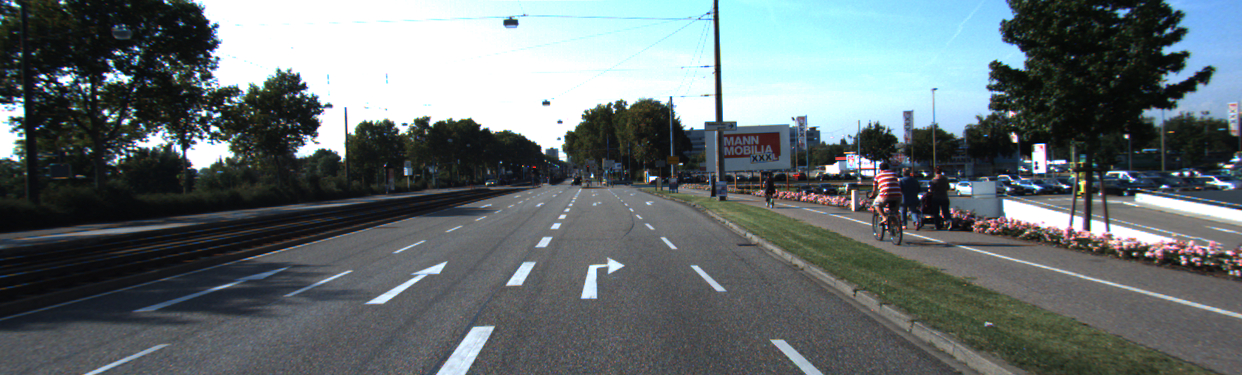

In [5]:
sample = ds_train.take(1)

# 이미지와 라벨 추출
for example in sample:
    print('----Example----')
    print(list(example.keys()))
    image = example['image']
    filename = example['image/file_name'].numpy().decode('utf-8')
    objects = example['objects']
    
print('-------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

width: 1242 height: 375
(5, 4)
[859.41    246.26001 910.98    156.75   ]
[897.28    229.47    926.81    162.37001]
[929.73 229.22 954.99 161.34]
[915.25995 228.36    946.53    189.32   ]
[761.87 207.59 776.46 169.34]
<PIL.Image.Image image mode=RGB size=1242x375 at 0x7EFC8D6A2250>


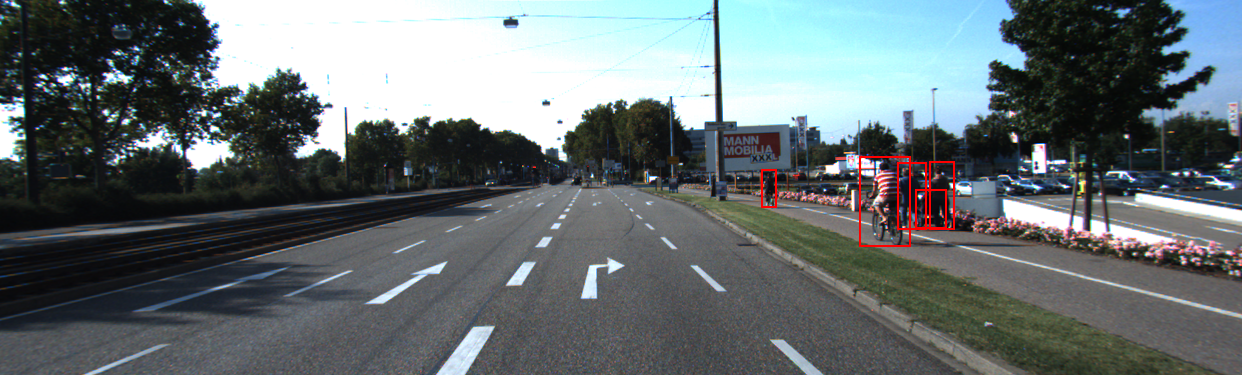

In [6]:
# 지이미지의 바운딩 박스 확인 - left, top, right, bottom
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)
    
    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, 'height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1] * width
    x_max = object_bbox[:, 3] * width
    y_min = height - object_bbox[:, 0] * height
    y_max = height - object_bbox[:, 2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## Model 불러오기 - RetinaNet

* Focal loss
* Feature pyramid network(FPN)


### 클래스 및 바운딩 박스 정보 추출

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox normalized coord. -> pixel-oriented coord.
        x_min = object_bbox[:, 1] * width
        x_max = object_bbox[:, 3] * width
        y_min = height - object_bbox[:, 2] * height
        y_max = height - object_bbox[:, 0] * height
        
        # 동일 이미지의 여러 object들을 한 줄씩 DataFrame 에 append
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                'img_path': img_path,
                'x1': _rect[0],
                'y1': _rect[1],
                'x2': _rect[2],
                'y2': _rect[3],
                'class_name': type_class_map[_type]
            }, ignore_index=True)
            
    
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [25:19<00:00,  4.18it/s]


In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:55<00:00,  4.04it/s]


In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map = {
        'car': 0,
        'person': 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")
    print('Done')
    
save_class_format(class_txt_path)


Done


---

* 모델 학습을 실행하기 전에 0번 스텝에서 requirement.txt 미리 설치해야함
* 학습시간 대략 50분 정도 소요됌

In [13]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt

2022-01-12 02:24:25.441599: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-12 02:24:27.530359: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 02:24:27.531583: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-12 02:24:27.558024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 02:24:27.558865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-12 02:24:27.558911: I tensorflow/stream_executor/platform/default/dso_lo

2022-01-12 02:24:33.984544: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-12 02:24:33.985321: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300015000 Hz
Epoch 1/10
2022-01-12 02:24:43.681826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-01-12 02:24:45.125422: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-01-12 02:24:45.161343: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-01-12 02:24:47.044281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-12 02:24:47.265452: I tensor

In [14]:
# 추론을 위해 실행 가능한 케라스 모델로 변환
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5

2022-01-12 03:03:54.233764: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-12 03:03:55.989783: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 03:03:55.990951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-12 03:03:56.018070: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 03:03:56.018967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8755GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2022-01-12 03:03:56.019021: I tensorflow/stream_executor/platform/default/dso_lo

---
## (3) 추론 및 시각화

In [15]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

import keras

import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv("HOME") + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


[591.853   174.61876 626.7529  206.6338 ] 0
[185.8979  132.83699 354.03232 231.17136] 0
[371.28317 183.59837 418.65756 210.91055] 0
[528.1858 158.5094 566.6298 192.9808] 0
[669.1309  155.91821 730.7512  194.27185] 0


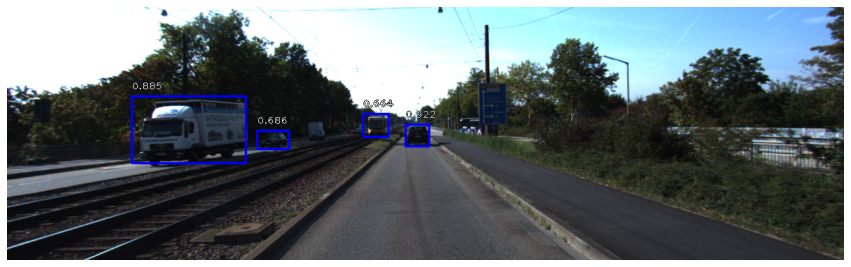

In [16]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box, label)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])

            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path)

[769.2469  141.39714 844.09766 295.1016 ] 1
[767.8758  138.3473  844.59155 292.8811 ] 0


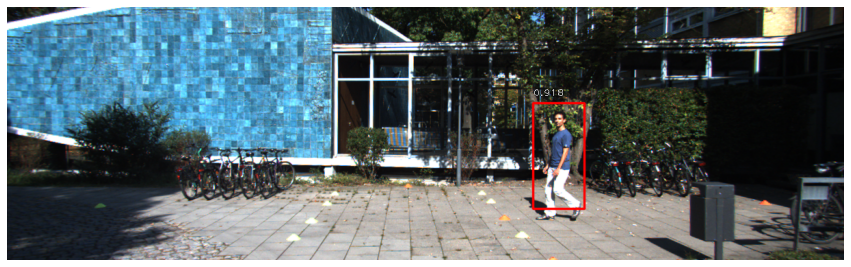

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)